In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Basic Datasets

In [35]:
temp_GA = pd.read_csv('data/open-meteo-glosseraletschgletscher.csv')

# Rename the column
temp_GA = temp_GA.rename(columns={'daily time': 'start date of observation'})

temp_GA = temp_GA.fillna(0)

In [36]:
length = pd.read_csv('data/lengthchange.csv')
length = length.replace(to_replace={'quality of start date':'x', 'quality of end date':'x', 'observer':'-'}, value=0).fillna(0)
length = length.iloc[2:]

# Convert column to numeric
length['length change'] = pd.to_numeric(length['length change'], errors='coerce')
length['elevation of glacier tongue'] = pd.to_numeric(length['elevation of glacier tongue'], errors='coerce')

length = length[length['glacier name']=='Grosser Aletschgletscher']

# Select specific columns
length = length[['start date of observation', 'length change', 'elevation of glacier tongue']]

In [37]:
mass = pd.read_csv('data/massbalance_fixdate.csv')
mass = mass.fillna(0)
mass = mass.iloc[2:]

mass = mass[mass['glacier name']=='Grosser Aletschgletscher']

mass = mass[['start date of observation', 'summer mass balance', 'equilibrium line altitude', 'accumulation area ratio', 'glacier area', 'minimum elevation of glacier', 'maximum elevation of glacier']]

# Convert to numeric
mass['summer mass balance'] = pd.to_numeric(mass['summer mass balance'], errors='coerce')
mass['equilibrium line altitude'] = pd.to_numeric(mass['equilibrium line altitude'], errors='coerce')
mass['accumulation area ratio'] = pd.to_numeric(mass['accumulation area ratio'], errors='coerce')
mass['glacier area'] = pd.to_numeric(mass['glacier area'], errors='coerce')
mass['minimum elevation of glacier'] = pd.to_numeric(mass['minimum elevation of glacier'], errors='coerce')
mass['maximum elevation of glacier'] = pd.to_numeric(mass['maximum elevation of glacier'], errors='coerce')

In [38]:
elevation = pd.read_csv(('data/massbalance_fixdate_elevationbins.csv'))
elevation = elevation.fillna(0)
elevation = elevation.iloc[2:]

elevation = elevation[elevation['glacier name']=='Grosser Aletschgletscher']

elevation = elevation[['start date of observation', 'annual mass balance', 'area of elevation bin', 'upper elevation of bin']]

# Convert start date of observation to datetime 
elevation['start date of observation'] = pd.to_datetime(elevation['start date of observation'])

# Convert 'annual mass balance', 'area of elevation bin', and 'upper elevation of bin' to numeric
elevation['annual mass balance'] = pd.to_numeric(elevation['annual mass balance'], errors='coerce')
elevation['area of elevation bin'] = pd.to_numeric(elevation['area of elevation bin'], errors='coerce')
elevation['upper elevation of bin'] = pd.to_numeric(elevation['upper elevation of bin'], errors='coerce')


elevation['start date of observation'] = pd.to_datetime(elevation['start date of observation'])

# Pivot the data to get 'upper elevation of bin' as columns, dates as index
pivot_elevation = elevation.pivot(index='start date of observation', columns='upper elevation of bin', values='annual mass balance').copy()

# Convert all columns except 'upper elevation of bin' to numeric
pivot_elevation = pivot_elevation.apply(pd.to_numeric, errors='coerce')
pivot_elevation.fillna(0, inplace=True)

bins_1700 = elevation[elevation['upper elevation of bin'] == 1700].copy()
bins_2900 = elevation[elevation['upper elevation of bin'] == 2900].copy()

# Satellite Imagery

In [39]:
white = pd.read_csv('results/167_38.csv')

# Convert 'date' to datetime format
white['date'] = pd.to_datetime(white['date'])

# Extract year from 'date'
white['year'] = white['date'].dt.year

# Group by the year and calculate mean and minimum of 'white'
white = white.groupby('year')['white'].agg(['mean', 'min']).reset_index()

# Rename the columns
white.columns = ['start date of observation', 'mean of white', 'minimum of white']

white['mean of white'] = pd.to_numeric(white['mean of white'], errors='coerce')
white['minimum of white'] = pd.to_numeric(white['minimum of white'], errors='coerce')

# Correlation Assessment

In [40]:
temp_GA['start date of observation'] = pd.to_datetime(temp_GA['start date of observation']).apply(lambda x: x.year)

# Reproject to year data (compute mean of all columns for each year) 
# date = index bcs groupby on index but don't want index so reset index
temp_GA = temp_GA.groupby('start date of observation').mean().reset_index()

# Convert each start date of observation to only year
length['start date of observation'] = pd.to_datetime(length['start date of observation']).apply(lambda x: x.year)
mass['start date of observation'] = pd.to_datetime(mass['start date of observation']).apply(lambda x: x.year)
bins_1700['start date of observation'] = pd.to_datetime(bins_1700['start date of observation']).apply(lambda x: x.year)
bins_2900['start date of observation'] = pd.to_datetime(bins_2900['start date of observation']).apply(lambda x: x.year)

# Reset index on all
length.reset_index(drop = True, inplace = True)
mass.reset_index(drop = True, inplace = True)
bins_1700.reset_index(drop = True, inplace = True)
bins_2900.reset_index(drop = True, inplace = True)

In [41]:
# Merging datasets
data_GA2 = pd.merge(temp_GA, length, on='start date of observation', how='inner')
data_GA2 = pd.merge(data_GA2, mass, on='start date of observation', how='inner')
data_GA2 = pd.merge(data_GA2, bins_1700, on='start date of observation', how='inner')
data_GA2 = pd.merge(data_GA2, bins_2900, on='start date of observation', how='inner')
data_GA2 = pd.merge(data_GA2, white, on='start date of observation', how='inner')

# Saving data_GA as a CSV file
data_GA2.to_csv('data/data_GA2.csv', index=False)

<Axes: >

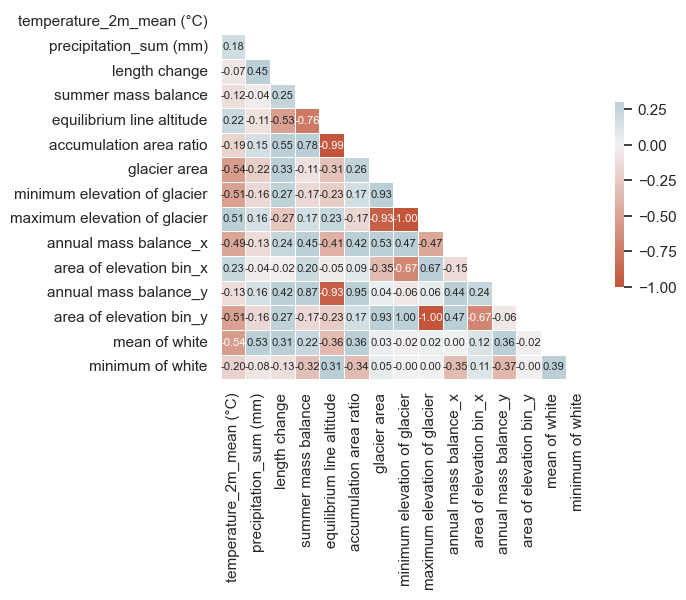

In [42]:
data_GA2.set_index('start date of observation', inplace=True)

# Keep columns
data_GA2 = data_GA2[['temperature_2m_mean (°C)', 'precipitation_sum (mm)', 'length change', 'summer mass balance', 'equilibrium line altitude', 'accumulation area ratio', 'glacier area', 'minimum elevation of glacier', 'maximum elevation of glacier', 'annual mass balance_x', 'area of elevation bin_x', 'annual mass balance_y', 'area of elevation bin_y', 'mean of white', 'minimum of white']]

# Compute cross-correlation between all tuples of columns
correlation_matrix = data_GA2.corr()

# Create the heat map
sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(20, 220, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f", annot_kws={"size": 8})

In [43]:
data_GA2.set_index('start date of observation', inplace=True)

# Keep columns
data_GA2 = data_GA2[['temperature_2m_mean (°C)', 'precipitation_sum (mm)', 'length change', 'summer mass balance', 'equilibrium line altitude', 'accumulation area ratio', 'glacier area', 'minimum elevation of glacier', 'maximum elevation of glacier', 'annual mass balance_x', 'area of elevation bin_x', 'annual mass balance_y', 'area of elevation bin_y', 'mean of white', 'minimum of white']]

# Compute cross-correlation between all tuples of columns
correlation_matrix = data_GA2.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
plt.matshow(correlation_matrix, cmap='coolwarm', fignum=1)
plt.colorbar()
plt.title('Correlation Matrix')

# Add correlation value on grid
for (i, j), val in np.ndenumerate(correlation_matrix):
    plt.text(j, i, f'{val:.2f}', ha='center', va='center', color='black')

plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation='vertical')
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.show()

KeyError: "None of ['start date of observation'] are in the columns"